# Assignment Sheet 4

Bruce Schultz  
bschultz@uni-bonn.de  
  
Miguel A. Ibarra-Arellano  
ibarrarellano@gmail.com

## Exercise 1

## Exercise 2

In [18]:
import numpy as np
from skimage import color
from sklearn import mixture
from scipy import misc, ndimage
import matplotlib.pyplot as plt
from IPython.display import Image

**a) Read the grayscale image brain.png, which is provided on the lecture homepage. Reduce the salt
and pepper noise in the image using a median filter. (3P)**

C:\Users\Bruce\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\Bruce\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


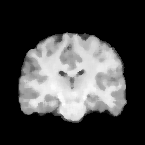

In [19]:
# Read image into array data
raw_img_read = misc.imread("brain-noisy.png", True)

# Denoising image
mf_img = ndimage.median_filter(raw_img_read, size=5)

misc.imsave('filtered_image.png', mf_img)
Image('filtered_image.png')

**b) Produce a binary mask that marks all pixels with an intensity greater than zero. In all further
steps, only treat pixels within that mask. (1P)**

C:\Users\Bruce\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


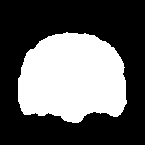

In [20]:
# Creating binary mask
binary_mask = mf_img > 0  # Any value greater than 0 (background)
bin_masked_img = mf_img.copy()
bin_masked_img[binary_mask] = 255  # 255 == white

misc.imsave('binary_mask.png', bin_masked_img)
Image('binary_mask.png')

**c) Plot a log-scaled histogram of the pixels within the mask. It should show how frequently different
intensity values occur in the image. What do the peaks in this histogram represent? Hint: One
way to and out is to create masks that highlight the pixels belonging to each peak. (4P)**

Text(0.5,1,'Brain image by pixel value')

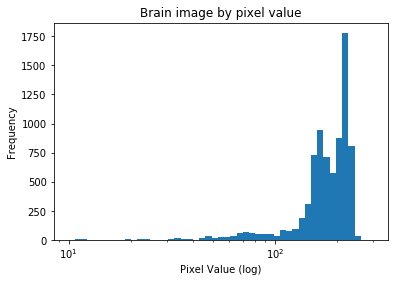

In [21]:
# Plot values from non-background pixels on a log scaled histogram
bins = 50
plt.gca().set_xscale("log")
counts, pixels, bars = plt.hist(mf_img[binary_mask], np.logspace(np.log10(10), np.log10(300), bins))
plt.xlabel("Pixel Value (log)")
plt.ylabel("Frequency")
plt.title("Brain image by pixel value")
# plt.show()  # Peaks refer to segmentation thresholds, gray/white matter and background

The peaks in this plot represent the different classes within the image, specifically the different parts of the brain. Each peak shows the pixel intensity that is most associated with that brain anatomy.

C:\Users\Bruce\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


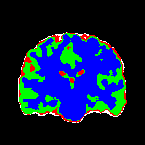

In [22]:
# Create masks for the pixel values surrounding each peak in histogram

# Determine histogram peaks and the corresponding pixel value
peak_values = []
threshold = 75
for i in range(len(counts)-1):
    if counts[i] > threshold and counts[i] > counts[i-1] and counts[i] > counts[i+1]:
        peak_values.append(pixels[i])

#  Visualize image with peak pixel value locations after converting to RGB array
masks = []
pix_range = 40  # To give an acceptable range for pixel values
for pix_value in peak_values:
    masks.append(np.logical_and(pix_value+pix_range >= mf_img, mf_img >= pix_value-pix_range))

peak_img = bin_masked_img.copy()
peak_img = color.gray2rgb(peak_img)  # Convert to RGB array
prime_colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255]]  # Define primary colors [R, G, B]
for counter, mask in enumerate(masks):
    if counter > 2:
        break
    peak_img[mask] = prime_colors[counter]
    
misc.imsave('peak_masks.png', peak_img)
Image('peak_masks.png')

Note that since I only used pixel intensities that were within 40 units of each peak, some pixels in the image remain white as they were not included in the range

**d) Now, we will use a three-compartment Gaussian Mixture Model for image segmentation: Based
on their gray level, pixels that fall within the mask from c) should be assigned to one of three
Gaussians, capturing corticospinal 
uid (dark), gray matter (medium), or white matter (bright).
To start this process, initialize the parameters of a three-compartment GMM to some reasonable
values and use them to compute the responsibilities pik of cluster k for pixel i. (4P)**

In [23]:
# Segmentation with Gaussian Mixture Model
# Generate numpy array to initialize GMM with, use random pixel numbers and theorized pixel peak values
points_init = np.array([[1, 2, 3], peak_values]).transpose()

gmm_data = np.column_stack(enumerate(mf_img[binary_mask])).transpose()  # Enumerate pixels with their grayscale values
gmm = mixture.GaussianMixture(n_components=3, means_init=points_init)  # 3 clusters
gmm.fit(gmm_data)  # Estimate model parameters with the EM algorithm

# "Responsibility" = conditional probability of point i belonging to cluster k
responsibilities = gmm.predict_proba(gmm_data)
cluster_predict = gmm.predict(gmm_data)

**e) Visualize the responsibilities by mapping the probabilities of belonging to the CSF, gray matter,
and white matter clusters to the red, blue, and green color channels, respectively. Please submit
the resulting image. (3P)**

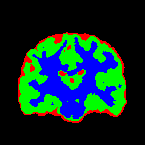

In [24]:
def pixel_cluster_matcher(mask_template, cluster_assignment_list, cluster_number):
    '''
    Uses a mask template to determine pixel location and iterates over new mask, changing Boolean\
    values to false if they don't match cluster_number
    :param mask_template: Mask_template to use to determine pixels of interest to change bool values
    :param cluster_assignment_list: 1D array with cluster assignment for every pixel that is True in mask_template
    :param cluster_number: Which cluster you are building this mask for
    :return: Mask with True values for only pixels at specified cluster_number location
    '''
    new_mask = mask_template.copy()
    k = 0
    for pixel in np.nditer(new_mask, op_flags=['readwrite']):
        if pixel[...]:
            if cluster_assignment_list[k] != cluster_number:
                pixel[...] = False
            k += 1
    return new_mask

# Map responsibilities/cluster predictions to image
prime_colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255]]  # Define primary colors [R, G, B]
gmm_img = bin_masked_img.copy()
gmm_img = color.gray2rgb(gmm_img)

# Create masks for CSF, gray/white matter then assign them color layers
csf_mask = pixel_cluster_matcher(binary_mask, cluster_predict, 0)
gray_mask = pixel_cluster_matcher(binary_mask, cluster_predict, 1)
white_mask = pixel_cluster_matcher(binary_mask, cluster_predict, 2)

gmm_img[csf_mask] = [0, 255, 0]
gmm_img[gray_mask] = [255, 0, 0]
gmm_img[white_mask] = [0, 0, 255]

Image('GMM_image.png')